# MUC16 phosphoproteomics cis comparison

## Step 1: Library Imports

Run this cell to import the necessary libraries

In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import scipy.stats
import re
import sys 
sys.path.append('C:\\Users\\brittany henderson\\GitHub\\WhenMutationsMatter\\Brittany\\')
import functions as f

import cptac
import cptac.algorithms as al

## Step 2: Find the frequently mutated genes for Endometrial Cancer

Enter the type of cancer and the cutoff for mutation frequency that you would like to use.

In [4]:
en_object = cptac.Endometrial()
desired_cutoff = .1

endometrial_freq_mut = al.get_frequently_mutated(en_object, cutoff = desired_cutoff)
print('\n\nNumber of Frequently Mutated Genes:', len(endometrial_freq_mut), '\n')
endometrial_freq_mut.loc[endometrial_freq_mut['Gene'] == 'MUC16']

                                    

Number of Frequently Mutated Genes: 232 



,Gene,Unique_Samples_Mut,Missence_Mut,Truncation_Mut
134,MUC16,0.189474,0.178947,0.052632


## Step 3: Select MUC16, a frequently mutated gene

In [3]:
gene = 'MUC16'

## Step 4: Select phosphoproteomics

In [5]:
omics = en_object.get_phosphoproteomics()

## Step 5: cis comparison 

Determine if the DNA mutation has an effect on the omics measurement. In order to do this, we have a few steps in code. The first three steps are found in the format_phospho_cis_comparison_data function.
1. get a table with both the omics and mutation data for tumors
2. get a binary column from the mutation data to separate our samples
3. format data frame to be used in the T-test
4. send data to the T-test.

In [12]:
# Create dataframe in order to do comparisons with wrap_ttest
omics_and_mut = en_object.join_omics_to_mutations(
    mutations_genes = gene, omics_df_name = 'phosphoproteomics', omics_genes = gene)

# Create the binary column needed to do the comparison
omics_and_mut['binary_mutations'] = omics_and_mut[gene+'_Mutation_Status'].apply(
    lambda x: 'Wildtype' if x == 'Wildtype_Tumor' else 'Mutated')

# Step 3 - format for loop (only phospho)
tumors = omics_and_mut.loc[omics_and_mut['Sample_Status'] == 'Tumor'] #drop Normal samples
columns_to_drop = [gene+"_Mutation", gene+"_Location", gene+"_Mutation_Status", "Sample_Status", "binary_mutations"]
only_phospho = tumors.drop(columns_to_drop, axis = 1)
print(len(only_phospho.columns), 'columns of phosphorylation sites')

7 columns of phosphorylation sites


In [15]:
print("Doing t-test comparison for mutation status\n")
pval_df = pd.DataFrame()
for col_label, content in only_phospho.items():
    formatted_phospho_df = f.format_phospho_cis_comparison(en_object, 'phosphoproteomics', gene, col_label)
    
    # check correctly formatted
    #check_binary = len(formatted_phospho_df['binary_mutations'].unique()) == 2
    check_num_data = len(formatted_phospho_df.index) > 9 # (95 * .1) = 9.5
    if check_num_data & check_num_data:
        omics_col_list = [col_label] #list of specific column label (for ttest)
        significant_pval_results = al.wrap_ttest(formatted_phospho_df, 'binary_mutations', omics_col_list)
        pval_df = pval_df.append(significant_pval_results, ignore_index = True)

pval_df # print to see significant tests

Doing t-test comparison for mutation status

Incorrectly Formatted Dataframe! Label column must have exactly 2 unique values.
No significant comparisons.
No significant comparisons.


""


In [16]:
# create data frame for boxplot with all sig sites
phospho_list = list(only_phospho.columns)
all_data = pd.DataFrame()
for phospho_name in phospho_list:
    real = omics_and_mut[[phospho_name, "binary_mutations"]].dropna(axis = 0) #drop rows with missing measurements
    concise_phospho_name = phospho_name.replace('_phosphoproteomics', '') #shorten col names
    real = real.assign(specific_phospho = concise_phospho_name)
    real = real.rename(columns={ real.columns[0]: "phosphoproteomics" })
    all_data = pd.concat([real, all_data], axis = 0)
#all_data.loc[all_data['specific_phospho'] == 'ARID1A-S1182']

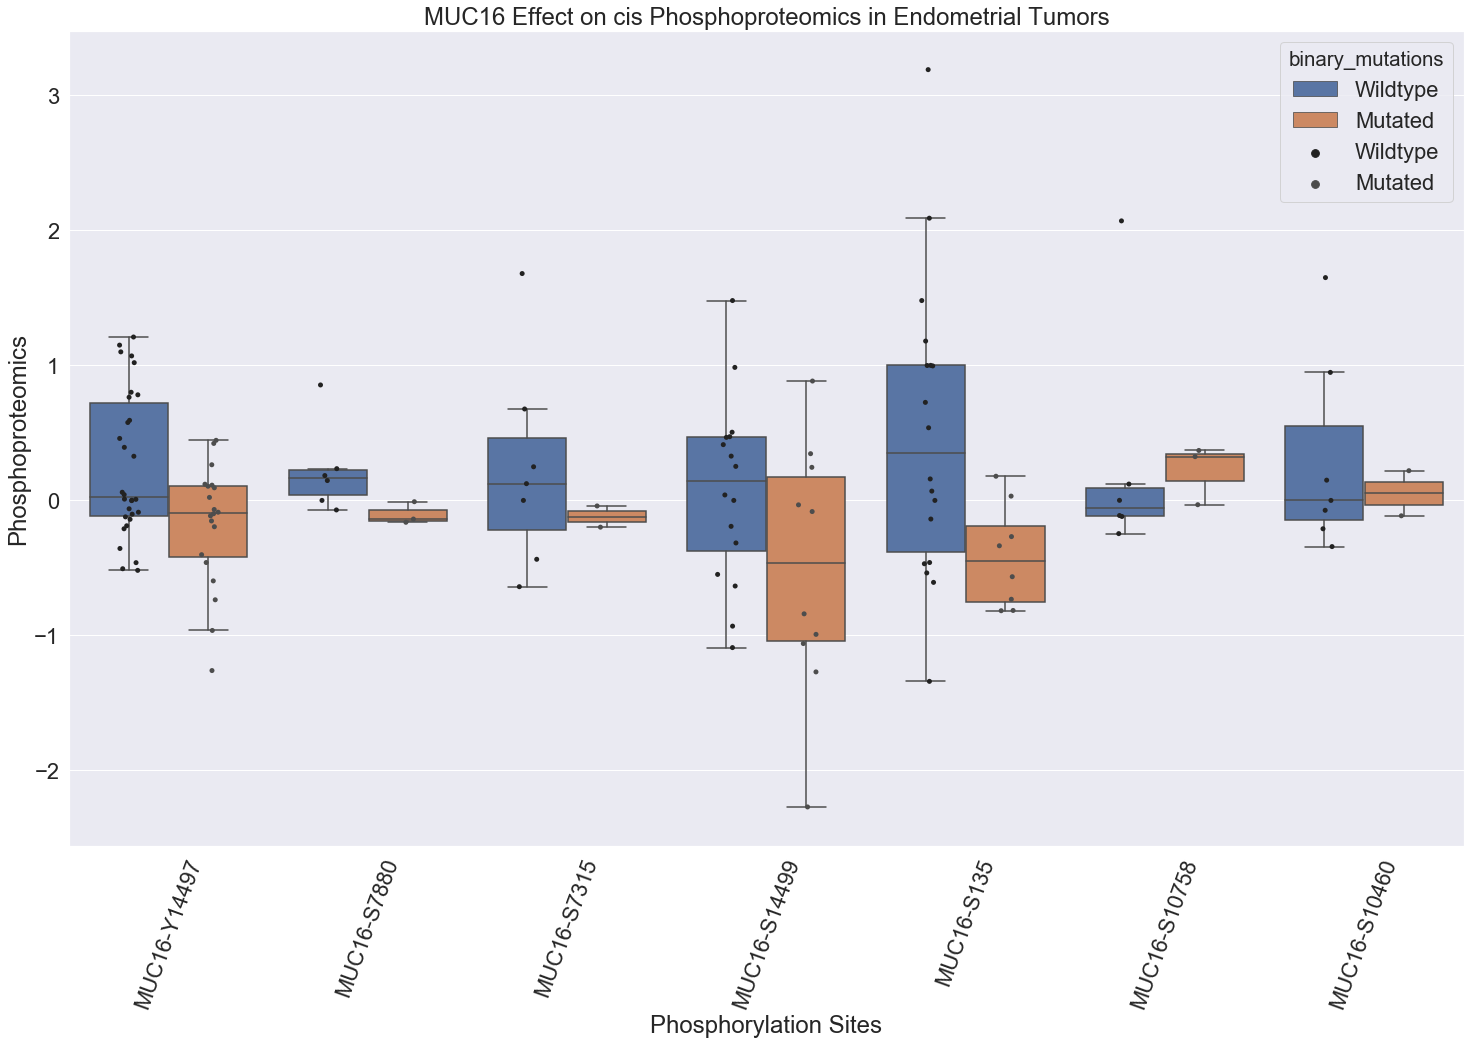

In [17]:
# Step 5 - Create boxplot to compare wildtype and mutated effect on omics data
plt.rcParams['figure.figsize']=(25,15) #size of plot
sns.set(font_scale = 2)
en_cis_boxplot = sns.boxplot(data = all_data, x = 'specific_phospho', y = 'phosphoproteomics', hue = 'binary_mutations',
                             hue_order = ["Wildtype","Mutated"], showfliers = False)  
en_cis_boxplot.set_title(gene + " Effect on cis Phosphoproteomics in Endometrial Tumors")
en_cis_boxplot = sns.stripplot(data= all_data, x = 'specific_phospho', y = 'phosphoproteomics', hue = 'binary_mutations',
                               hue_order = ["Wildtype","Mutated"], jitter = True, color = ".3", dodge = True)
en_cis_boxplot.set(xlabel = 'Phosphorylation Sites', ylabel = "Phosphoproteomics")
en_cis_boxplot.set_xticklabels(en_cis_boxplot.get_xticklabels(),rotation=70)
plt.show()
plt.clf()
plt.close()

No significant comparisons.

Mutation type comparison

In [19]:
# check all or just sig from last test?
mutation_type_pval = pd.DataFrame()
for name in phospho_list:
    formated_phospho = f.get_missence_truncation_phospho(en_object, 'phosphoproteomics', gene, name)
    check_num_sample = len(formated_phospho) > 9
    if check_num_sample:
        omics_col_list = [name] #list of specific column label (for ttest)
        significant_pval_results = al.wrap_ttest(formated_phospho, 'binary_mutations', omics_col_list)
        mutation_type_pval = mutation_type_pval.append(significant_pval_results, ignore_index = True)
mutation_type_pval

""


Not enough data for comparison of mutation type.

# Repeat with the Colon dataset

Go through the same process, this time using the Colon dataset.

In [21]:
colon_object = cptac.Colon()
desired_cutoff = .1

colon_freq_mut = al.get_frequently_mutated(colon_object, cutoff = desired_cutoff)
print('\n\nNumber of Frequently Mutated Genes:', len(colon_freq_mut), '\n')
colon_freq_mut.loc[colon_freq_mut['Gene'] == 'MUC16']

                                    

Number of Frequently Mutated Genes: 39 



,Gene,Unique_Samples_Mut,Missence_Mut,Truncation_Mut
16,MUC16,0.402062,0.360825,0.072165


In [23]:
gene = 'MUC16'

co_omics = colon_object.get_phosphoproteomics()

In [24]:
omics_mutations = colon_object.join_omics_to_mutations(
        mutations_genes = gene, omics_df_name = 'phosphoproteomics', omics_genes = gene)

No data for MUC16 phosphoproteomics in the colon dataset. Not possible to do cis comparison.

# Repeat with the Ovarian dataset

In [29]:
ov_object = cptac.Ovarian()
desired_cutoff = .1

ov_freq_mut = al.get_frequently_mutated(ov_object, cutoff = desired_cutoff)
print('\n\nNumber of Frequently Mutated Genes:', len(ov_freq_mut), '\n')
ov_freq_mut.loc[ov_freq_mut['Gene'] == 'MUC16']

                                    

Number of Frequently Mutated Genes: 16 



,Gene,Unique_Samples_Mut,Missence_Mut,Truncation_Mut
6,MUC16,0.144578,0.144578,0.012048


In [27]:
gene = 'MUC16'

ov_omics = ov_object.get_phosphoproteomics()

In [28]:
omics_mutations = colon_object.join_omics_to_mutations(
        mutations_genes = gene, omics_df_name = 'phosphoproteomics', omics_genes = gene)

No data for MUC16 phosphoproteomics in the ovarian dataset. Not possible to do cis comparison.

# Analysis of Results

The endometrial dataset was the only dataset to have MUC16 phosphoproteomics. No comparisons were significant.